# Exploratory Data Analysis

**Ziele**:
- Daten verstehen
- Eventuelle Probleme identifizieren

In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from plotly.offline import init_notebook_mode
import seaborn as sns
import nltk

import os
from utils.text_utils import clean_text, get_most_common_words, get_most_common_ngrams 
from utils.plot_utils import plot_ngrams_counts, plot_words_counts

nltk.download('punkt')
nltk.download('stopwords')
init_notebook_mode(connected=True)
sns.set_style("darkgrid")
plt.rcParams['figure.figsize'] = [20, 8]

[nltk_data] Downloading package punkt to /home/x/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/x/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Herunterladen der Datensätze
Wir verwenden die Kaggle API, um zwei Datensätze herunterzuladen. Für eine reibungslose Authentifizierung ist es erforderlich, zunächst einen Kaggle-Account zu erstellen und danach einen entsprechenden Zugriffstoken zu generieren.

Die Datensätze:
- McDonalds Reviews
- IMDB Reviews

Wichtig: Bei Verwendung von Google Colab muss die Datei `kaggle.json`, die die API-Zugangsdaten enthält, hochgeladen werden. Ohne diese Schritte kann die nächste Code-Zelle nicht erfolgreich ausgeführt werden.

In [86]:
# from google.colab import files

# uploaded = files.upload()

# for fn in uploaded.keys():
#   print('User uploaded file "{name}" with length {length} bytes'.format(
#       name=fn, length=len(uploaded[fn])))
  
# # Then move kaggle.json into the folder where the API expects to find it.
# !mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

In [87]:
# Download McDonalds dataset
if not os.path.exists('mcdonalds-store-reviews.zip'):
    print("Downloading McDonalds dataset...")
    !kaggle datasets download -d nelgiriyewithana/mcdonalds-store-reviews
if os.path.exists('mcdonalds-store-reviews.zip'):
    print("Unzipping McDonalds dataset...")
    !unzip -n mcdonalds-store-reviews.zip

# Download IMDB dataset
if not os.path.exists('imdb-dataset-of-50k-movie-reviews.zip'):
    print("Downloading IMDB dataset...")
    !kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
if os.path.exists('imdb-dataset-of-50k-movie-reviews.zip'):
    print("Unzipping IMDB dataset...")
    !unzip -n imdb-dataset-of-50k-movie-reviews.zip

Unzipping McDonalds dataset...
/usr/bin/zsh: /home/x/miniconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /usr/bin/zsh)
Archive:  mcdonalds-store-reviews.zip
Unzipping IMDB dataset...
/usr/bin/zsh: /home/x/miniconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /usr/bin/zsh)
Archive:  imdb-dataset-of-50k-movie-reviews.zip


## Laden der Datensätze

In [88]:
df_mcd = pd.read_csv('McDonald_s_Reviews.csv', encoding='latin-1')
df_imdb = pd.read_csv('IMDB Dataset.csv')

## Erster Überblick 

**McDonalds Reviews**

In [89]:
df_mcd.head()   

,reviewer_id,store_name,category,store_address,latitude,longitude,rating_count,review_time,review,rating
0,1,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",3 months ago,Why does it look like someone spit on my food?...,1 star
1,2,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",5 days ago,It'd McDonalds. It is what it is as far as the...,4 stars
2,3,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",5 days ago,Made a mobile order got to the speaker and che...,1 star
3,4,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",a month ago,My mc. Crispy chicken sandwich was ï¿½ï¿½ï¿½ï¿...,5 stars
4,5,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",2 months ago,"I repeat my order 3 times in the drive thru, a...",1 star


**IMDB Reviews**

In [90]:
df_imdb.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


Die Datensätze enthalten neben den Rezensionstexten und Bewertungen noch einige weitere Daten. Da unser Fokus in der nachfolgenden Analyse jedoch ausschließlich auf den Textdaten und den zugehörigen Bewertungen liegt, können wir diese spezifischen Daten extrahieren.

In [91]:
# Only keep the text and the sentiment
df_mcd = df_mcd[['review', 'rating']]
df_imdb = df_imdb[['review', 'sentiment']]  

Wir können ebenfalls beobachten, dass die Labels kategorischer Natur sind und in Form von Strings vorliegen. Um diese Labels effektiver nutzen zu können, werden wir sie zunächst in ein numerisches Format umwandeln. Im Falle des IMDB-Datensatzes wird 'positive' in 1 und 'negative' in 0 umgewandelt. Das Gleiche gilt für die McDonalds Reviews, wobei '1 star' einer 1 entspricht und '5 stars' einer 5.

Grundsätzlich lässt sich bereits festhalten, dass die Klassifizierungsprobleme hier einerseits eine 'Binäre Klassifizierung' und andererseits eine 'Mehrklassen-Klassifizierung' darstellen. Für die Visualisierung ist dies zunächst kein Problem. Allerdings sollte bei einer späteren Zusammenführung berücksichtigt werden, inwiefern die kategorialen Daten entweder als positiv (1) oder negativ (0) umgewandelt werden müssen.

In [92]:
mcd_rating_map = {
    '1 star': 1,
    '2 stars': 2,
    '3 stars': 3,
    '4 stars': 4,
    '5 stars': 5,
}
df_mcd['rating'] = df_mcd['rating'].map(mcd_rating_map)
df_imdb['sentiment'] = df_imdb['sentiment'].map({'positive': 1, 'negative': 0})

# Align column names
df_mcd = df_mcd.rename(columns={'review': 'text', 'rating': 'sentiment'})
df_imdb = df_imdb.rename(columns={'review': 'text', 'sentiment': 'sentiment'})

In [93]:
df_mcd.head()   

,text,sentiment
0,Why does it look like someone spit on my food?...,1
1,It'd McDonalds. It is what it is as far as the...,4
2,Made a mobile order got to the speaker and che...,1
3,My mc. Crispy chicken sandwich was ï¿½ï¿½ï¿½ï¿...,5
4,"I repeat my order 3 times in the drive thru, a...",1


In [94]:
df_mcd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33396 entries, 0 to 33395
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       33396 non-null  object
 1   sentiment  33396 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 521.9+ KB


In [95]:
df_imdb.head(5) 

,text,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [96]:
df_imdb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       50000 non-null  object
 1   sentiment  50000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 781.4+ KB


### Anzal der Einträge

In [97]:
print("McDonalds dataset has {} entries".format(len(df_mcd)))
for i in range(1, 6):
    print("McDonalds dataset has {} entries with {} stars".format(len(df_mcd[df_mcd['sentiment'] == i]), i))

print('-' * 50)

print("IMDB dataset has {} entries".format(len(df_imdb)))
for i in range(0, 2):
    print("IMDB dataset has {} entries with {} sentiment".format(len(df_imdb[df_imdb['sentiment'] == i]), 'positive' if i == 1 else 'negative'))

McDonalds dataset has 33396 entries
McDonalds dataset has 9431 entries with 1 stars
McDonalds dataset has 3086 entries with 2 stars
McDonalds dataset has 4818 entries with 3 stars
McDonalds dataset has 5787 entries with 4 stars
McDonalds dataset has 10274 entries with 5 stars
--------------------------------------------------
IMDB dataset has 50000 entries
IMDB dataset has 25000 entries with negative sentiment
IMDB dataset has 25000 entries with positive sentiment


### Einige Samples von jedem Datensatz

In [98]:
mcd_samples = df_mcd['text'][:5].values
print("McDonalds dataset text samples:\n")
for i, sample in enumerate(mcd_samples):
    print("Sample {}: {}\n".format(i + 1, sample))    

McDonalds dataset text samples:

Sample 1: Why does it look like someone spit on my food?
I had a normal transaction,  everyone was chill and polite, but now i dont want to eat this. Im trying not to think about what this milky white/clear substance is all over my food, i d*** sure am not coming back.

Sample 2: It'd McDonalds. It is what it is as far as the food and atmosphere go. The staff here does make a difference. They are all friendly, accommodating and always smiling. Makes for a more pleasant experience than many other fast food places.

Sample 3: Made a mobile order got to the speaker and checked it in.
Line was not moving so I had to leave otherwise Iï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½d be late for work.
Never got the refund in the app.
I called them and they said I could only get my money back in person because it was stuck in the system.
Went there in person the next day  and the manager told me she wasnï¿

Sample 4: My mc. Cri

In [99]:
imdb_samples = df_imdb['text'][:5].values
print("IMDB dataset text samples:\n")
for i, sample in enumerate(imdb_samples):
    print("Sample {}: {}\n".format(i + 1, sample))

IMDB dataset text samples:

Sample 1: One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the mai

### Erste Probleme der Datensätze

 Das Auftreten des Zeichens 'ï¿½', das als Platzhalter für nicht erkannte ASCII-Zeichen dient, deutet auf ein Encoding-Problem im McDonalds Datensatz hin. Bei der Betrachtung des Datensatzes im .csv-Format zeigt sich jedoch, dass das Problem nicht durch die Verwendung von pandas beim Einlesen der Daten entstanden ist, sondern bereits zuvor vorhanden war. 
 
 Ebenfalls sehen wir in den Beispielen des IMDB Datensatzes, das HTML-Tags in den Sätzen vorhanden sind. Dieses kann waehrend der Sentimentanalyse ein Problem sein, da sie Kontext hinzufügen, der für Maschinen schwer zu interpretieren ist.

Im Folgenden werden wir den Datensatz bereinigen. Neben der Entfernung von Nicht-ASCII-Zeichen und HTML-Tags führen wir weitere Maßnahmen durch, um verlässliche Ergebnisse zu erzielen. Für die Sentimentanalyse irrelevante Daten, wie Satzzeichen und URLs, werden entfernt. Zudem ermöglicht die Umwandlung aller Buchstaben in Kleinbuchstaben ("lower-casing"), dass Wörter mit derselben Bedeutung, wie zum Beispiel "Hund", "hund" und "HUnD", nicht als unterschiedliche Begriffe behandelt werden. Insgesamt reduziert diese Vorgehensweise die Komplexität der Daten.

### Reinigen der Datensätze

Es wäre in diesem Zusammenhang sicherlich auch interessant, Verfahren wie "Stopword-Removal", "Stemming" und "Lemmatization" in Betracht zu ziehen.
- Stopword-Removal: entfernt häufig vorkommende Wörter, die wenig zur Bedeutung eines Textes beitragen.
- Stemming: reduziert Wörter auf ihren Stamm oder ihre Basis. Zum Beispiel werden "jumps", "jumping" und "jumped" alle auf "jump" reduziert.
- Lemmatization: reduziert Wörter auf ihre lexikalische Grundform und bietet eine höhere semantische Genauigkeit als das Stemming.

Wir haben einige Experimente mit der Entfernung von Stoppwörtern durchgeführt. Allerdings stellten wir fest, dass gerade bei der Sentimentanalyse diese Wörter oft wichtige Kontextinformationen liefern. Aus diesem Grund haben wir uns letztendlich dazu entschieden, sie nicht zu entfernen.

Die `clean_text` Funktion ist in unserem `utils`-Modul definiert.

In [100]:
og_mcd_text = df_mcd['text'][3]
df_mcd['text'] = df_mcd['text'].apply(clean_text)

print('McDondalds Original Text: {}'.format(og_mcd_text))
print('McDonalds Cleaned Text: {}\n'.format(df_mcd['text'][3]))

og_imdb_text = df_imdb['text'][1]
df_imdb['text'] = df_imdb['text'].apply(clean_text)

print('IMDB Original Text: {}'.format(og_imdb_text))
print('IMDB Cleaned Text: {}'.format(df_imdb['text'][1]))

McDondalds Original Text: My mc. Crispy chicken sandwich was ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ customer service was quick and p
McDonalds Cleaned Text: my mc crispy chicken sandwich was  customer service was quick and p

IMDB Original Text: A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only "has got all the polari" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master's of comedy and his life. <br /><br />The realism really comes home with the little things: the fantasy of t

## Datenverteilung

### McDonalds Datensatz

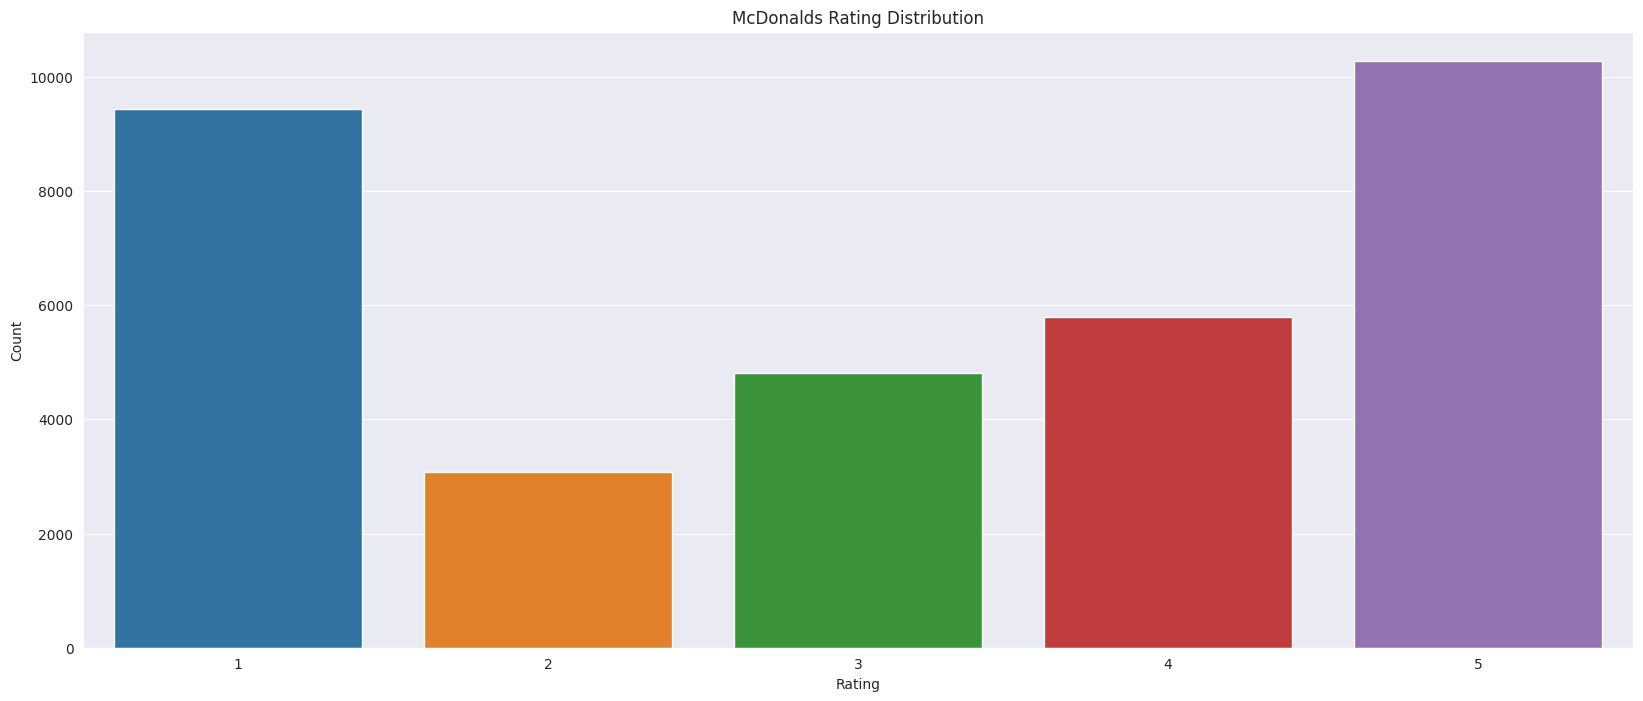

In [101]:
# McDonalds Rating Distribution
sns.countplot(x='sentiment', data=df_mcd)
plt.title('McDonalds Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

### IMDB Datensatz

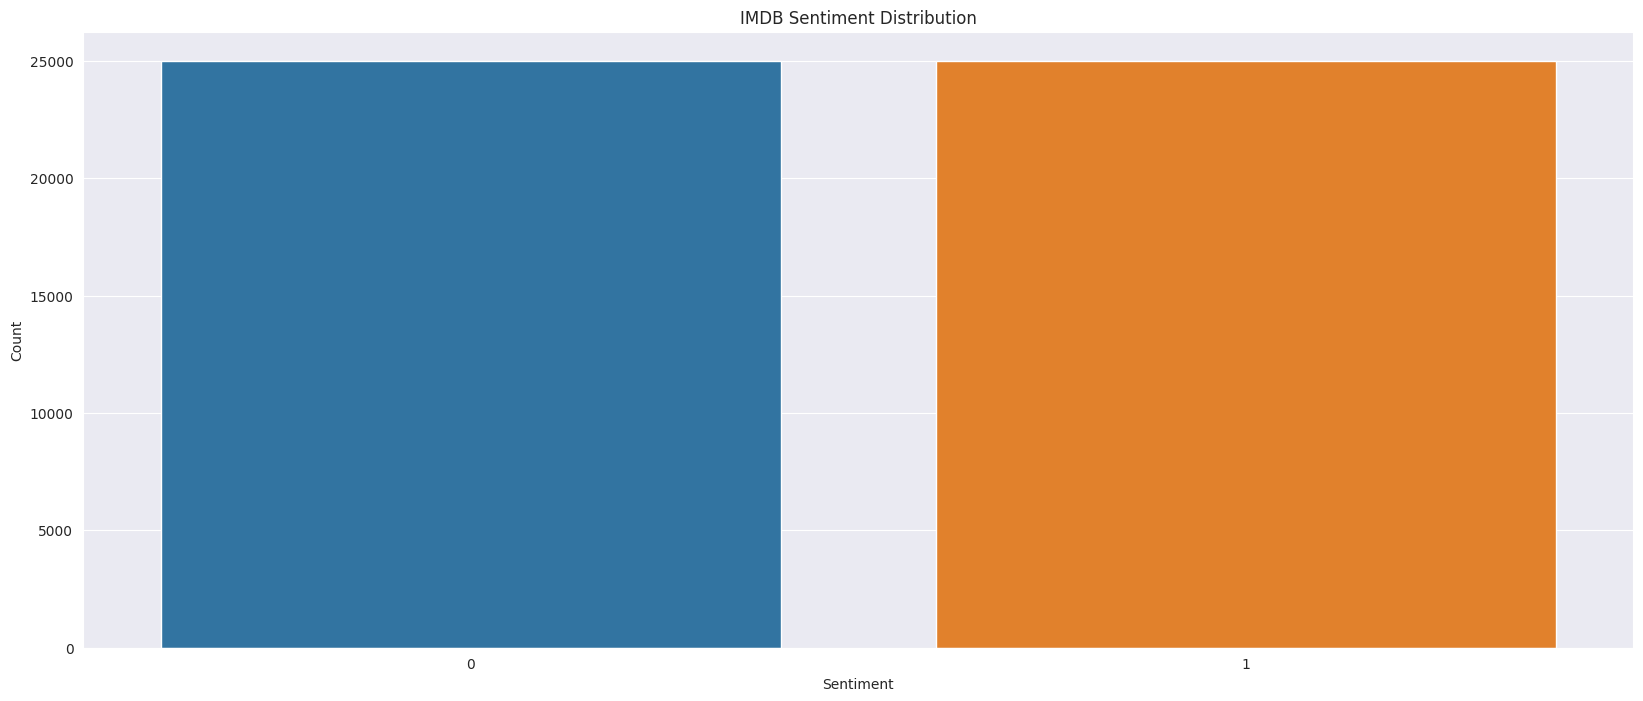

In [102]:
# IMDB Sentiment Distribution
sns.countplot(x='sentiment', data=df_imdb)
plt.title('IMDB Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

## Detaillierte Betrachtung des McDonalds-Datensatzes

- Anzahl der Zeichen pro Kategorie
- Anzahl der Wörter pro Kategorie
- Durchschnittliche Wortlänge pro Kategorie
- Häufigste Wörter
- Häufigste Bigramme / Trigramme / Quadgramme

In [103]:
df_mcd['char_count'] = df_mcd['text'].apply(len)
df_mcd['word_count'] = df_mcd['text'].apply(lambda x: len(x.split()))
df_mcd['mean_word_length'] = df_mcd['text'].apply(lambda x: np.mean([len(word) for word in x.split()]) if x.strip() else 0)
df_mcd.head()     

,text,sentiment,char_count,word_count,mean_word_length
0,why does it look like someone spit on my food\...,1,253,53,3.773585
1,it would mcdonalds it is what it is as far as ...,4,235,43,4.488372
2,made a mobile order got to the speaker and che...,1,328,70,3.685714
3,my mc crispy chicken sandwich was customer se...,5,67,12,4.583333
4,i repeat my order 3 times in the drive thru an...,1,306,63,3.793651


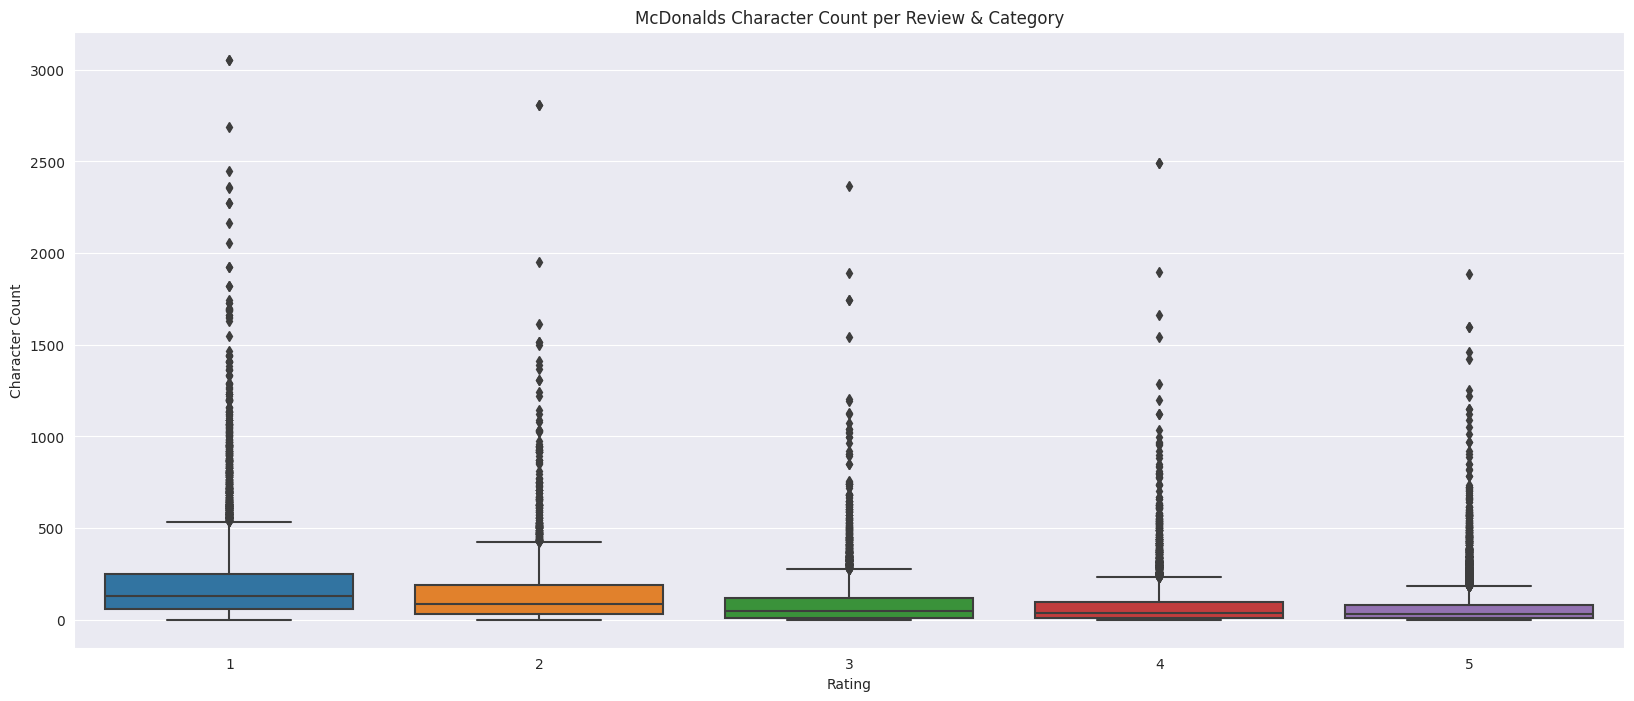

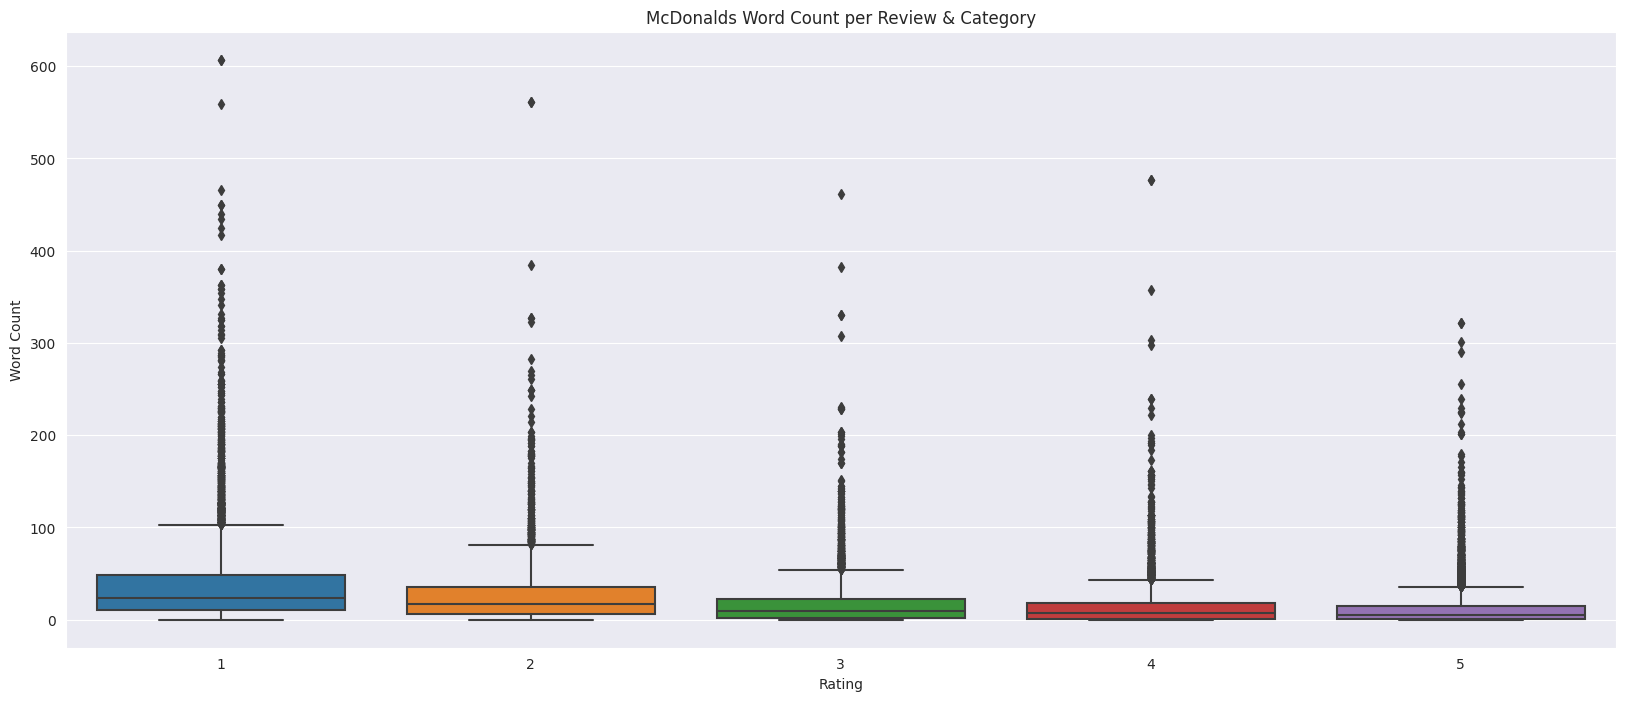

In [104]:
# character count
sns.boxplot(x='sentiment', y='char_count', data=df_mcd)
plt.title('McDonalds Character Count per Review & Category')
plt.xlabel('Rating')
plt.ylabel('Character Count')   
plt.show()

# word count
sns.boxplot(x='sentiment', y='word_count', data=df_mcd) 
plt.title('McDonalds Word Count per Review & Category')
plt.xlabel('Rating')
plt.ylabel('Word Count')
plt.show()

In [105]:
df_mean_lengths = df_mcd.groupby('sentiment').agg({'mean_word_length': 'mean'}).reset_index()

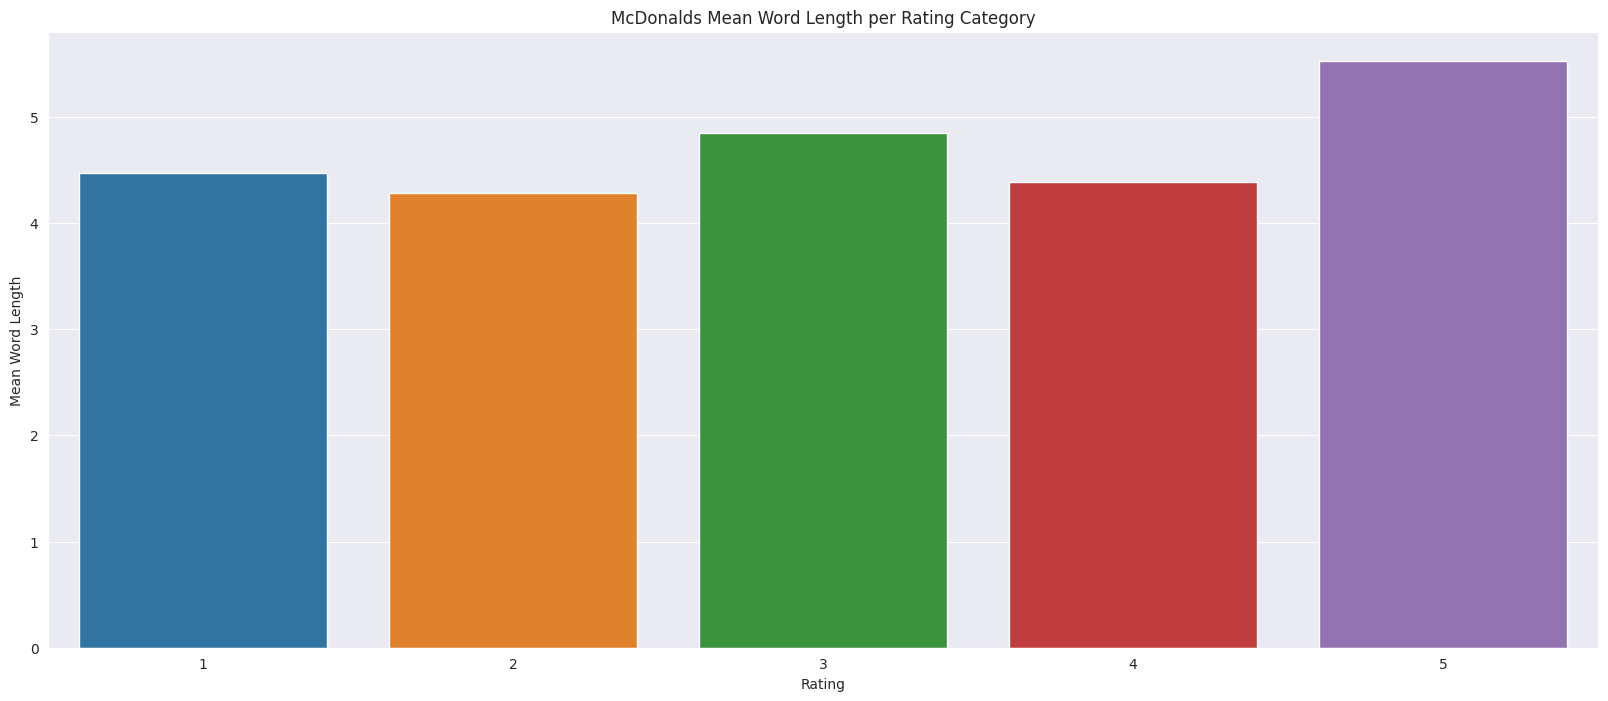

In [106]:
sns.barplot(x='sentiment', y='mean_word_length', data=df_mean_lengths)
plt.title('McDonalds Mean Word Length per Rating Category')
plt.xlabel('Rating')
plt.ylabel('Mean Word Length')  
plt.show()

Die vorangegangenen Diagramme enthüllen durchaus interessante Aspekte. Im Allgemeinen lässt sich feststellen, dass negative Bewertungen tendenziell länger sind. Dies legt nahe, dass unzufriedene Kunden ausführlicheres Feedback geben.

In [107]:
df_mcd.drop(['char_count', 'word_count', 'mean_word_length'], axis=1, inplace=True)
df_mcd.head()

,text,sentiment
0,why does it look like someone spit on my food\...,1
1,it would mcdonalds it is what it is as far as ...,4
2,made a mobile order got to the speaker and che...,1
3,my mc crispy chicken sandwich was customer se...,5
4,i repeat my order 3 times in the drive thru an...,1


### Häufigkeit von Begriffen

Nachfolgend machen wir von unseren Utility-Funktionen Gebrauch, um die häufigsten Wörter und Ngramme in den Datensätzen zu erlangen und darzustellen.

Die Funktionen sind in dem `utils` Modul definiert.

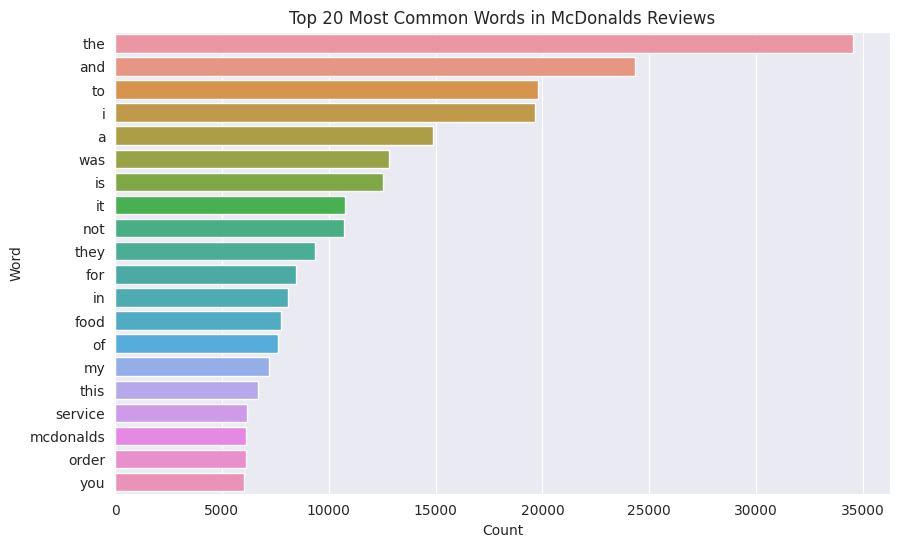

In [108]:
most_common_words = get_most_common_words(df_mcd, 'text', 20)
plot_words_counts(most_common_words, 'Top 20 Most Common Words in McDonalds Reviews')

### Häufigkeit von N-grammen
Einzelne Wörter liefern oft nicht den gesamten Kontext und können je nach Position im Satz sogar völlig unterschiedliche Bedeutungen annehmen. Durch die Betrachtung von N-grammen, also n zusammenhängende Wörter, erlangen wir ein besseres Verständnis für den Kontext, in dem Wörter eingesetzt werden. Diese Analyse hilft zudem dabei, gängige Phrasen und Ausdrücke zu identifizieren, die häufig in Bewertungen verwendet werden, wie beispielsweise 'good service' oder 'cold food'.

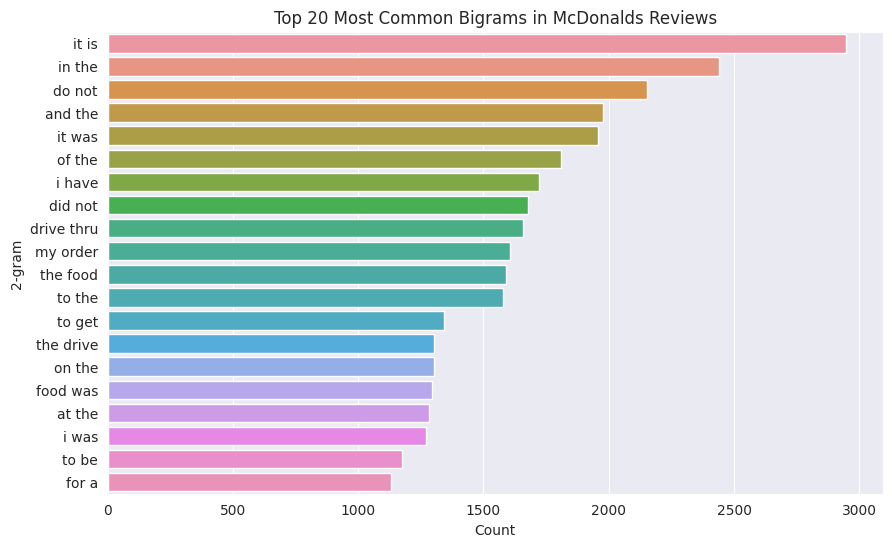

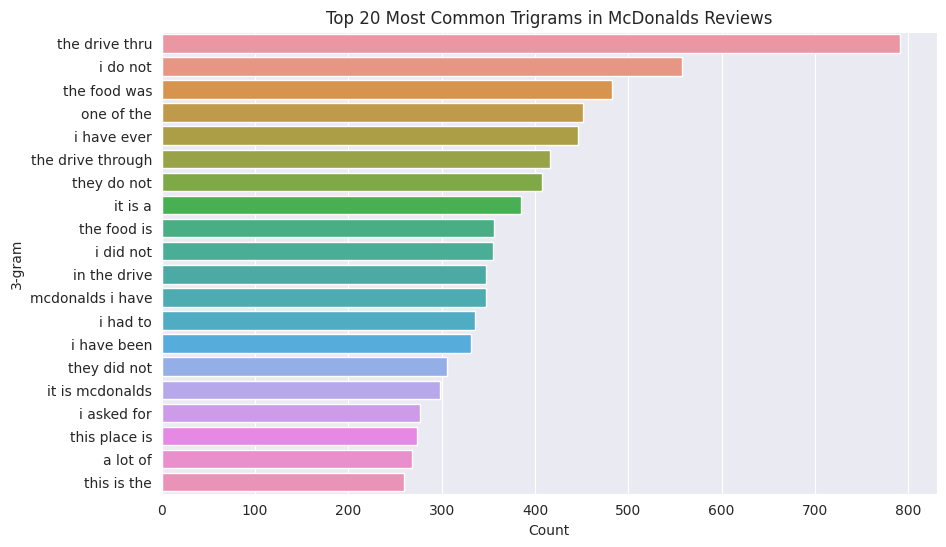

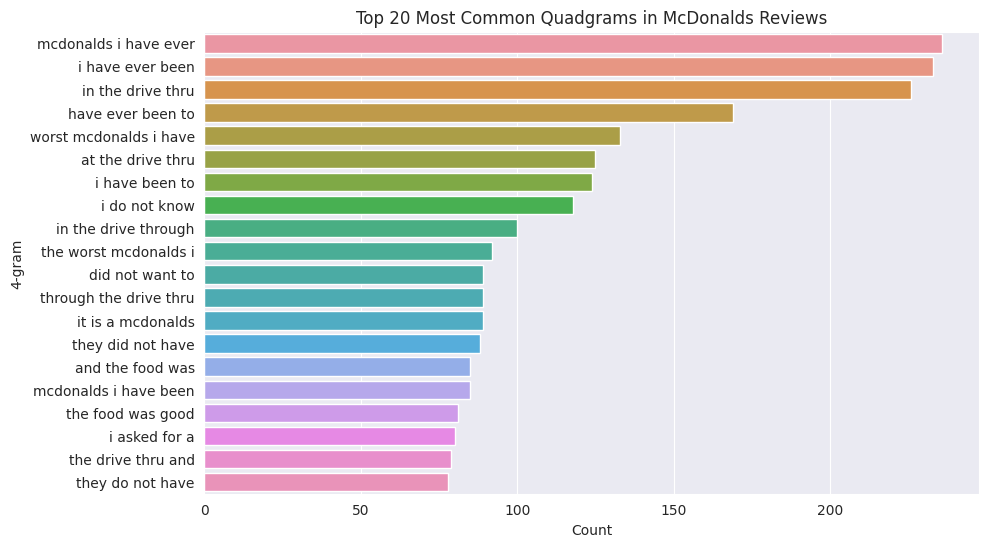

In [109]:
most_common_bigrams = get_most_common_ngrams(df_mcd, 'text', 2, 20)
most_common_trigrams = get_most_common_ngrams(df_mcd, 'text', 3, 20)
most_common_quadgrams = get_most_common_ngrams(df_mcd, 'text', 4, 20)

plot_ngrams_counts(most_common_bigrams, 'Top 20 Most Common Bigrams in McDonalds Reviews')
plot_ngrams_counts(most_common_trigrams, 'Top 20 Most Common Trigrams in McDonalds Reviews')
plot_ngrams_counts(most_common_quadgrams, 'Top 20 Most Common Quadgrams in McDonalds Reviews')

Viele der erscheinenden Bi- und Trigramme liefern auf den ersten Blick nicht unbedingt aussagekräftige Informationen, da sie überwiegend aus Stoppwörtern zusammengesetzt sind. Darüber hinaus ist es herausfordernd, aus dem Kontext von nur zwei bis drei Wörtern eine klare Sentimenteinschätzung zu treffen. Erst die Betrachtung von Quadgrammen, also Zusammenhängen von vier Wörtern, beginnt ein deutlicheres Bild des Sentiments abzuzeichnen.

Für eine gründlichere Analyse werden wir in den folgenden Schritten positive und negative Bewertungen getrennt untersuchen. So können wir mögliche Tendenzen in den Wortabfolgen besser verstehen.

### Aufteilung in 'positive' und 'negative' Bewertungen

Da die Labels des McDonalds-Datensatzes mehrere Klassen ('multiclass') umfassen, müssen wir zunächst festlegen, welche Bewertungen als 'positiv' und welche als 'negativ' eingestuft werden. Aus Gründen der Einfachheit haben wir uns für die folgende Einteilung entschieden:

- Bewertungen mit der Note 3 werden entfernt, da sie weder als positiv noch als negativ eingestuft werden können
- Bewertungen mit einer Note kleiner als 3 werden als negativ eingestuft
- Bewertungen mit einer Note größer als 3 werden als positiv eingestuft

In [110]:
# Remove 3 star reviews
df_mcd = df_mcd[df_mcd['text'] != 3]
df_mcd.head()

,text,sentiment
0,why does it look like someone spit on my food\...,1
1,it would mcdonalds it is what it is as far as ...,4
2,made a mobile order got to the speaker and che...,1
3,my mc crispy chicken sandwich was customer se...,5
4,i repeat my order 3 times in the drive thru an...,1


In [111]:
# Map to binary
df_mcd['sentiment'] = df_mcd['sentiment'].map(lambda x: 1 if x > 3 else 0)  
df_mcd.head()

,text,sentiment
0,why does it look like someone spit on my food\...,0
1,it would mcdonalds it is what it is as far as ...,1
2,made a mobile order got to the speaker and che...,0
3,my mc crispy chicken sandwich was customer se...,1
4,i repeat my order 3 times in the drive thru an...,0


In [112]:
positive_reviews = df_mcd[df_mcd['sentiment'] == 1]
negative_reviews = df_mcd[df_mcd['sentiment'] == 0]

print('Number of Positive Reviews: {}'.format(len(positive_reviews)))
print('Number of Negative Reviews: {}'.format(len(negative_reviews)))

print('Percent of Positive Reviews: {}%'.format(round(len(positive_reviews) / len(df_mcd) * 100, 2)))
print('Percent of Negative Reviews: {}%'.format(round(len(negative_reviews) / len(df_mcd) * 100, 2)))

Number of Positive Reviews: 16061
Number of Negative Reviews: 17335
Percent of Positive Reviews: 48.09%
Percent of Negative Reviews: 51.91%


Der Datensatz weist eine leichte Tendenz zu negativen Bewertungen auf, allerdings ist diese nicht besonders ausgeprägt. Die Verteilung der Bewertungen liegt nahezu bei einem 50-50 Verhältnis zwischen positiven und negativen Bewertungen, was auf eine relative Ausgewogenheit des Datensatzes hindeutet. 

**Positive Reviews**

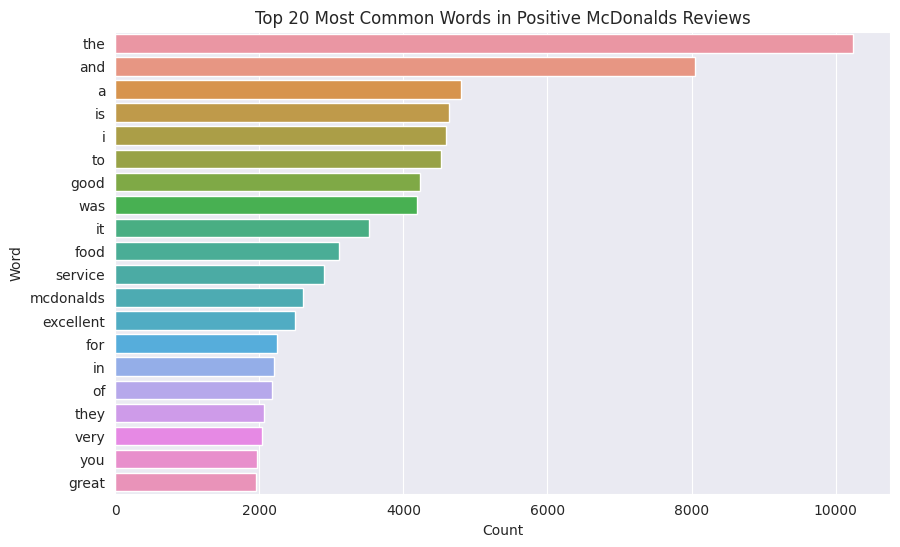

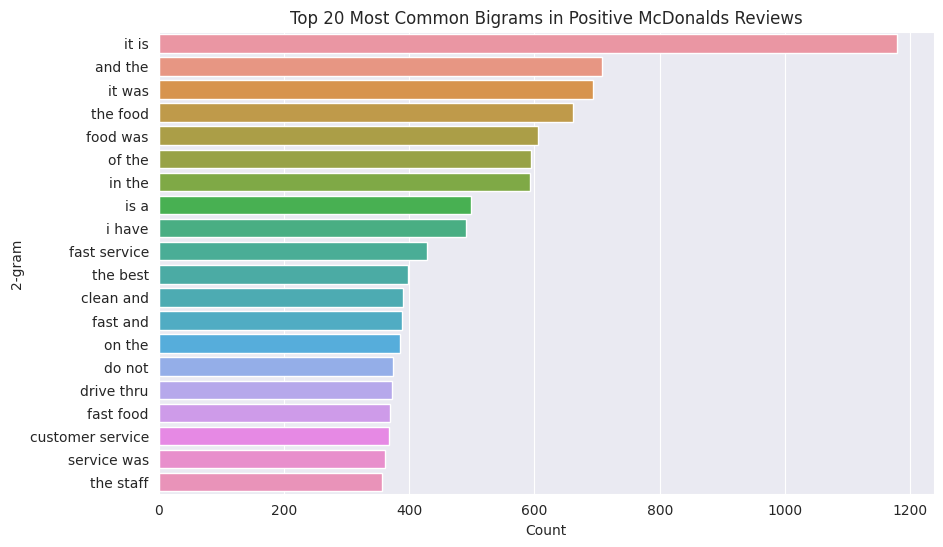

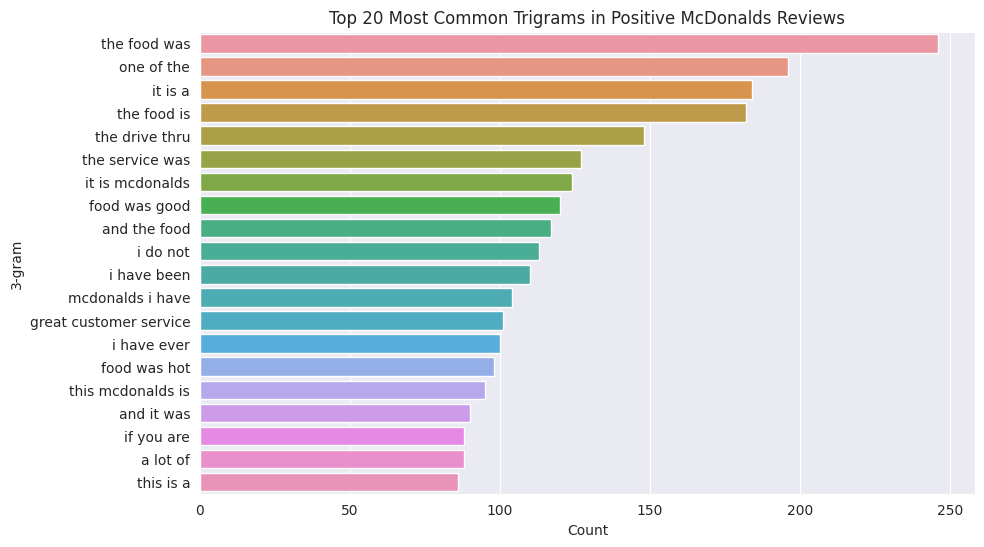

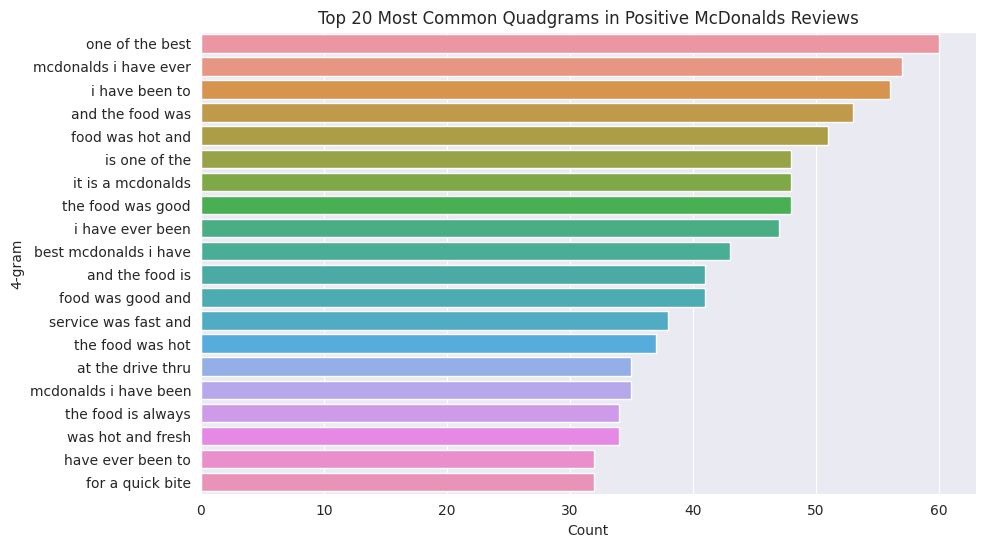

In [113]:
most_common_pos_words = get_most_common_words(positive_reviews, 'text', 20)
most_common_pos_bigrams = get_most_common_ngrams(positive_reviews, 'text', 2, 20)
most_common_pos_trigrams = get_most_common_ngrams(positive_reviews, 'text', 3, 20)
most_common_pos_quadgrams = get_most_common_ngrams(positive_reviews, 'text', 4, 20)

plot_words_counts(most_common_pos_words, 'Top 20 Most Common Words in Positive McDonalds Reviews')
plot_ngrams_counts(most_common_pos_bigrams, 'Top 20 Most Common Bigrams in Positive McDonalds Reviews')
plot_ngrams_counts(most_common_pos_trigrams, 'Top 20 Most Common Trigrams in Positive McDonalds Reviews')
plot_ngrams_counts(most_common_pos_quadgrams, 'Top 20 Most Common Quadgrams in Positive McDonalds Reviews')

**Negative Reviews**

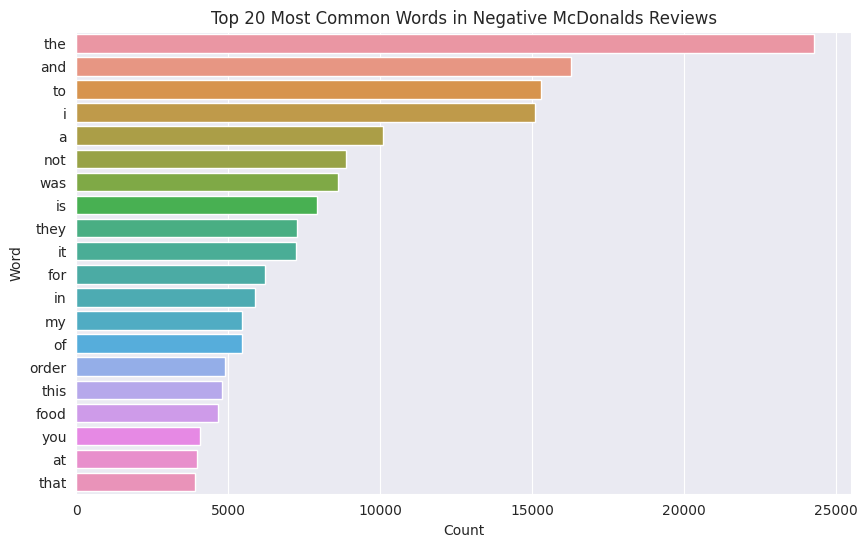

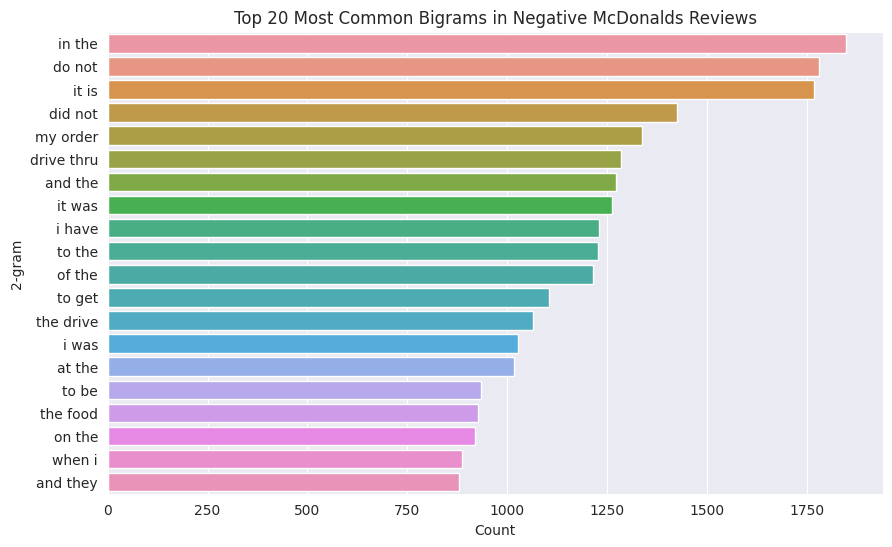

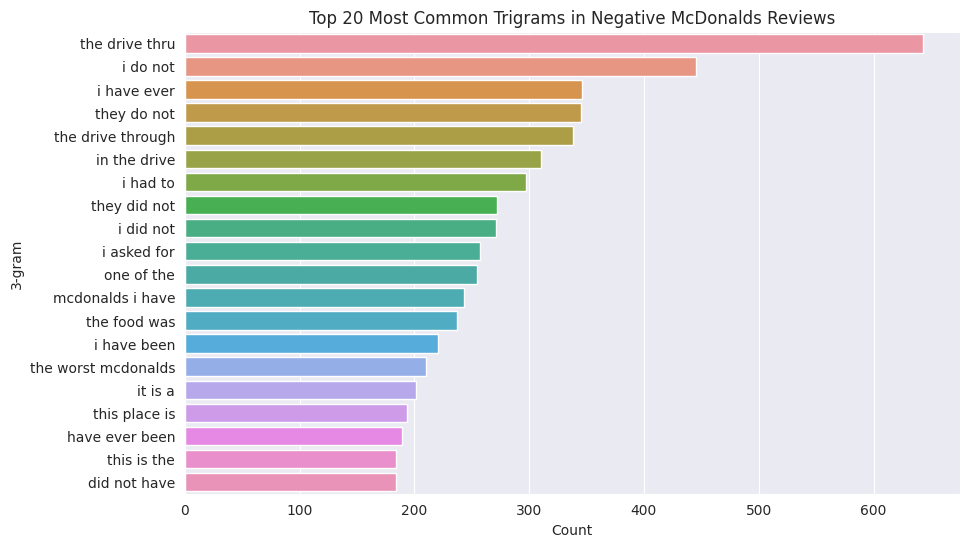

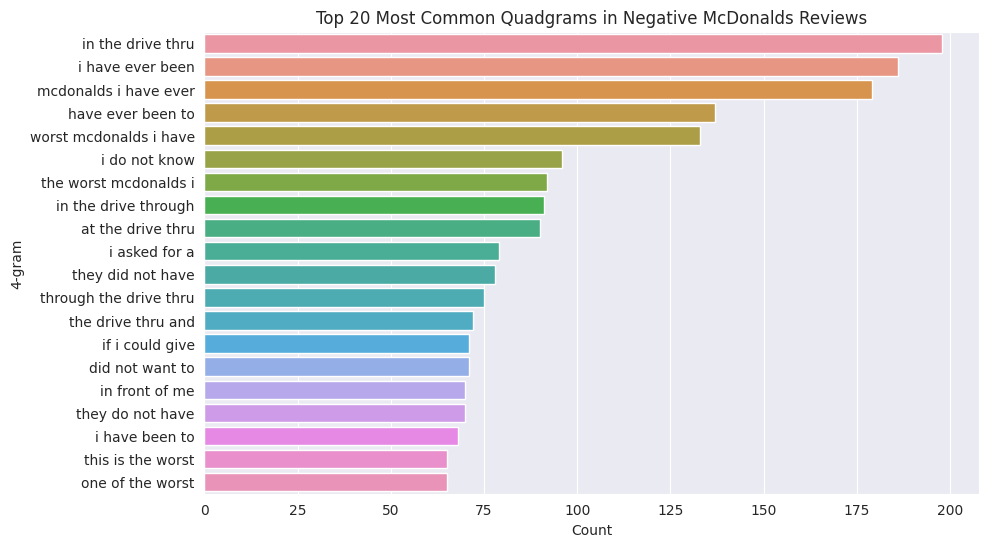

In [114]:
most_common_neg_words = get_most_common_words(negative_reviews, 'text', 20)
most_common_neg_bigrams = get_most_common_ngrams(negative_reviews, 'text', 2, 20)
most_common_neg_trigrams = get_most_common_ngrams(negative_reviews, 'text', 3, 20)
most_common_neg_quadgrams = get_most_common_ngrams(negative_reviews, 'text', 4, 20)

plot_words_counts(most_common_neg_words, 'Top 20 Most Common Words in Negative McDonalds Reviews')
plot_ngrams_counts(most_common_neg_bigrams, 'Top 20 Most Common Bigrams in Negative McDonalds Reviews')
plot_ngrams_counts(most_common_neg_trigrams, 'Top 20 Most Common Trigrams in Negative McDonalds Reviews')
plot_ngrams_counts(most_common_neg_quadgrams, 'Top 20 Most Common Quadgrams in Negative McDonalds Reviews')

## Detaillierte Betrachtung des IMDB-Datensatzes

- Anzahl der Zeichen pro Kategorie
- Anzahl der Wörter pro Kategorie
- Durchschnittliche Wortlänge pro Kategorie
- Häufigste Wörter
- Häufigste Bigramme / Trigramme / Quadgramme

In [115]:
df_imdb['char_count'] = df_imdb['text'].apply(len)
df_imdb['word_count'] = df_imdb['text'].apply(lambda x: len(x.split()))
df_imdb['mean_word_length'] = df_imdb['text'].apply(lambda x: np.mean([len(word) for word in x.split()]) if x.strip() else 0)
df_imdb.head()

,text,sentiment,char_count,word_count,mean_word_length
0,one of the other reviewers has mentioned that ...,1,1684,308,4.470779
1,a wonderful little production the filming tech...,1,936,156,5.006410
2,i thought this was a wonderful way to spend ti...,1,882,164,4.384146
3,basically there is a family where a little boy...,0,694,132,4.242424
4,petter matteis love in the time of money is a ...,1,1237,222,4.576577


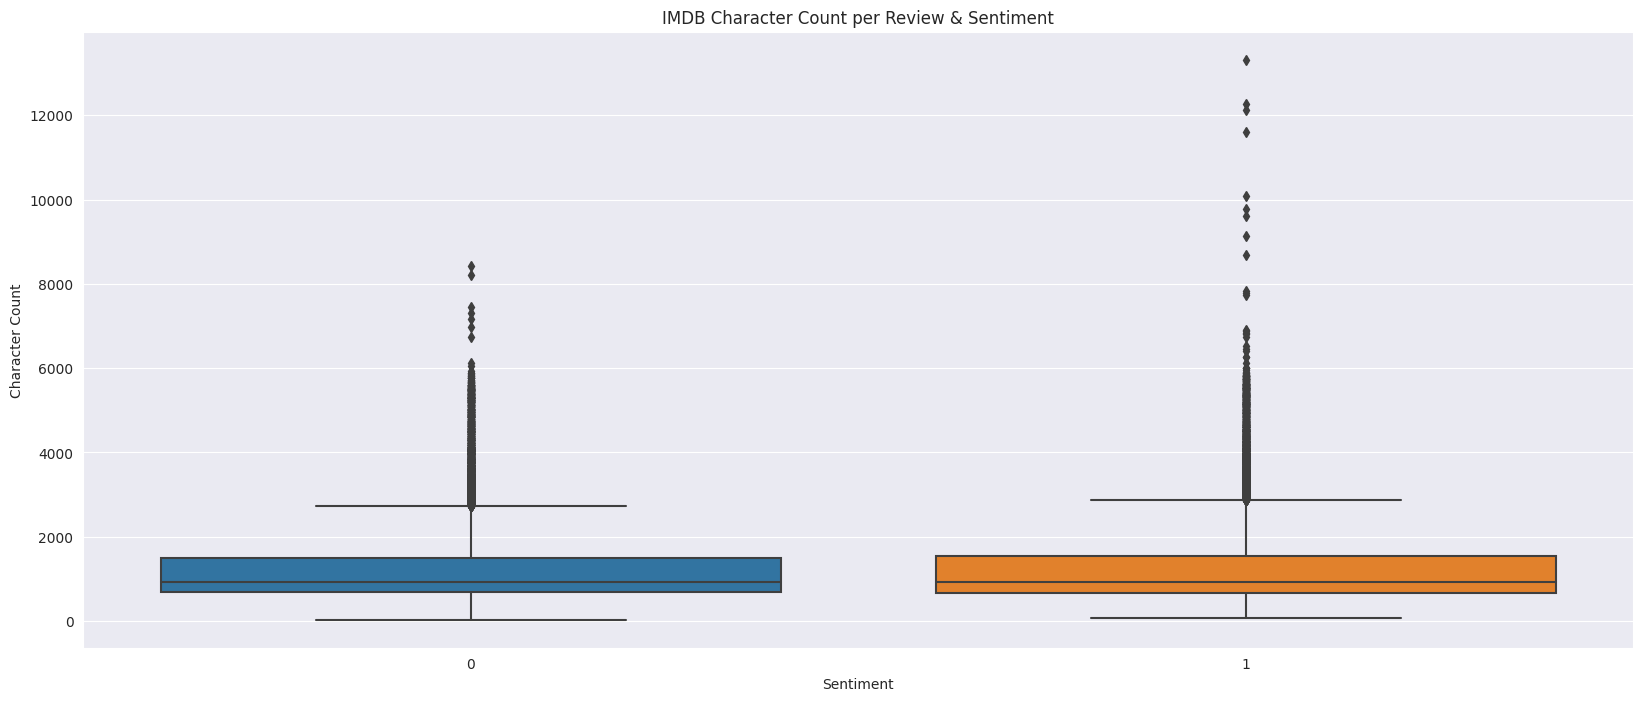

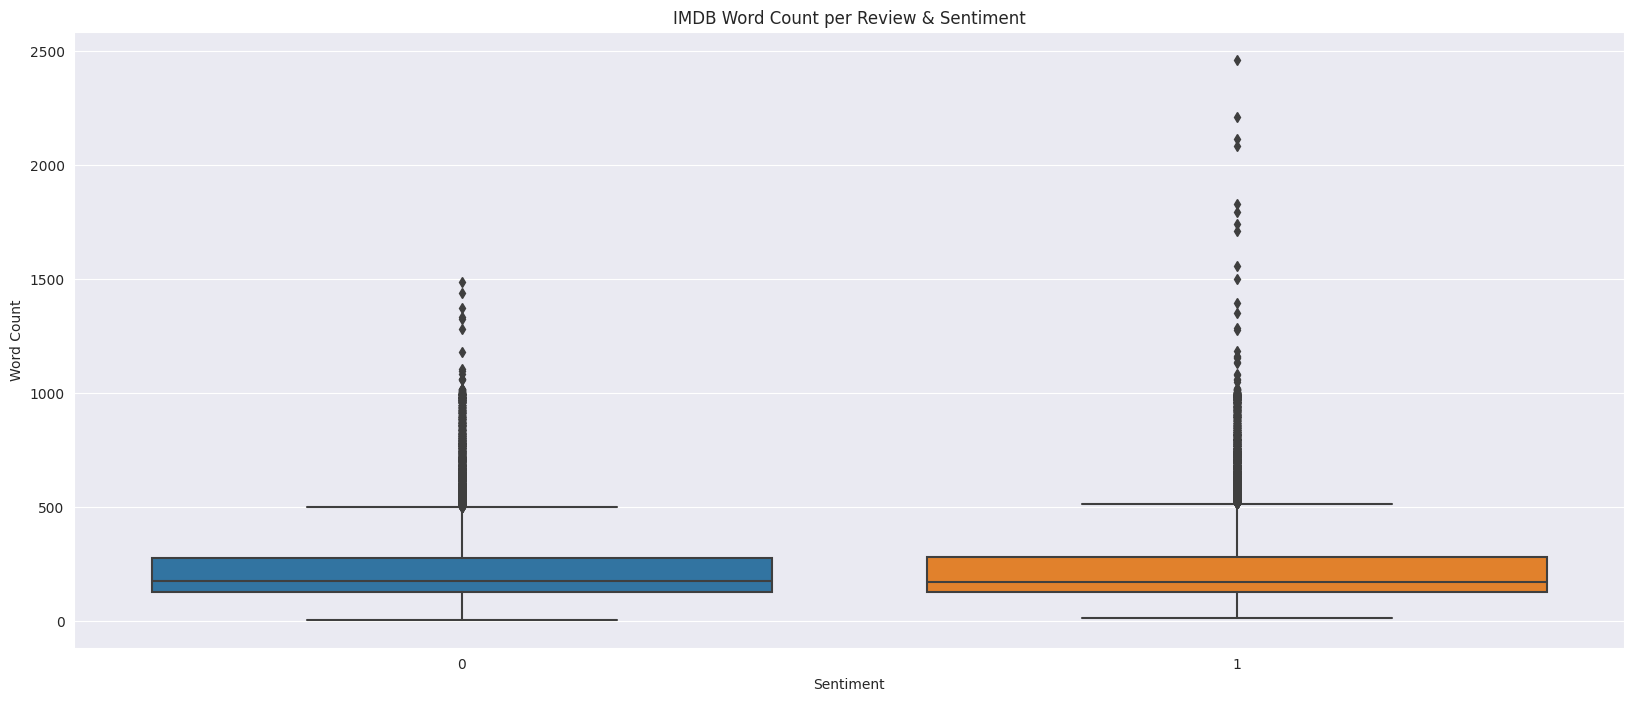

In [116]:
# Character count
sns.boxplot(x='sentiment', y='char_count', data=df_imdb)
plt.title('IMDB Character Count per Review & Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Character Count')   
plt.show()

# Word count
sns.boxplot(x='sentiment', y='word_count', data=df_imdb) 
plt.title('IMDB Word Count per Review & Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Word Count')
plt.show()


In [117]:
df_mean_lengths = df_imdb.groupby('sentiment').agg({'mean_word_length': 'mean'}).reset_index()

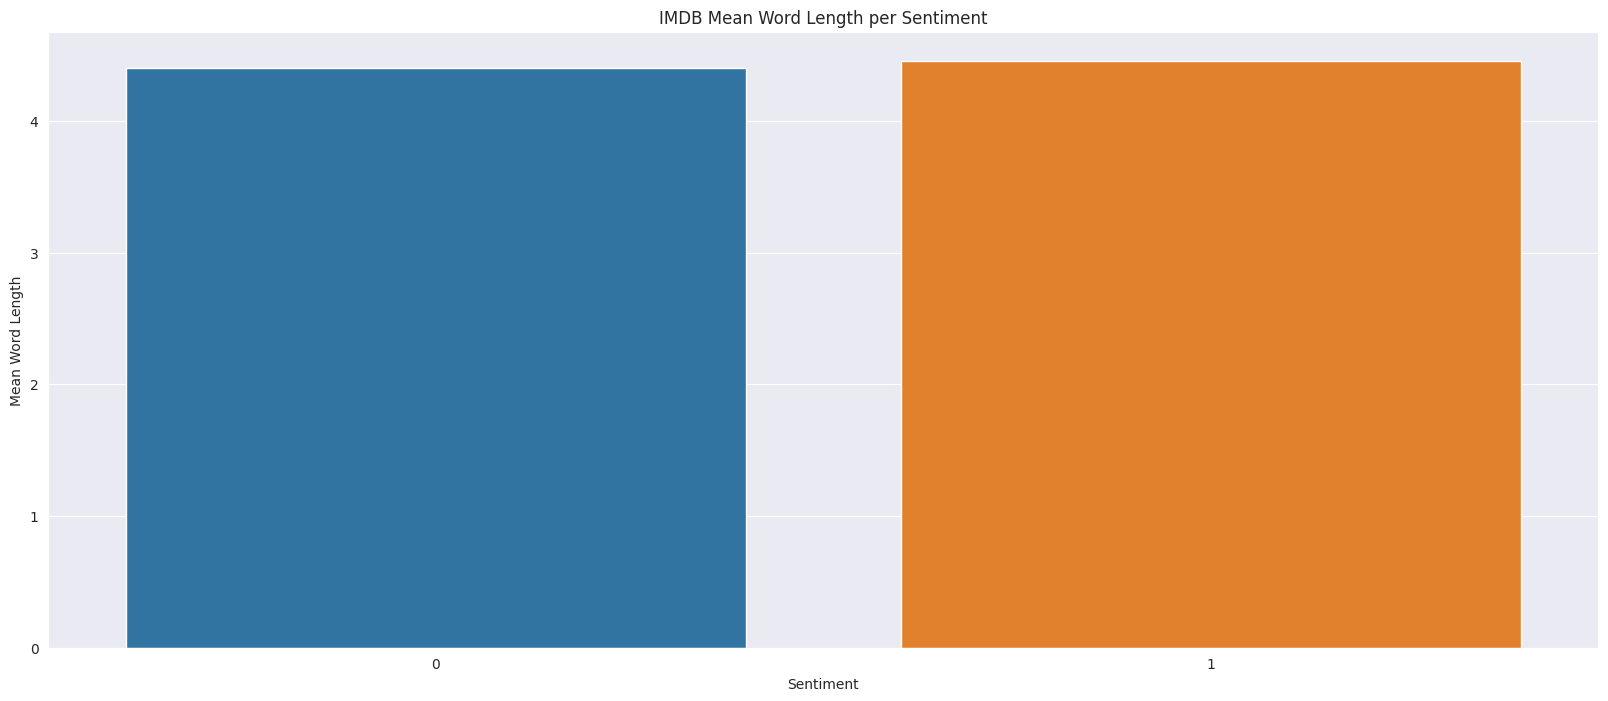

In [118]:
# plot mean word length
sns.barplot(x='sentiment', y='mean_word_length', data=df_mean_lengths)
plt.title('IMDB Mean Word Length per Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Mean Word Length')      
plt.show()

In [119]:
# clean up added columns 
df_imdb.drop(['char_count', 'word_count', 'mean_word_length'], axis=1, inplace=True)
df_imdb.head()

,text,sentiment
0,one of the other reviewers has mentioned that ...,1
1,a wonderful little production the filming tech...,1
2,i thought this was a wonderful way to spend ti...,1
3,basically there is a family where a little boy...,0
4,petter matteis love in the time of money is a ...,1


### Häufigkeit von Begriffen 

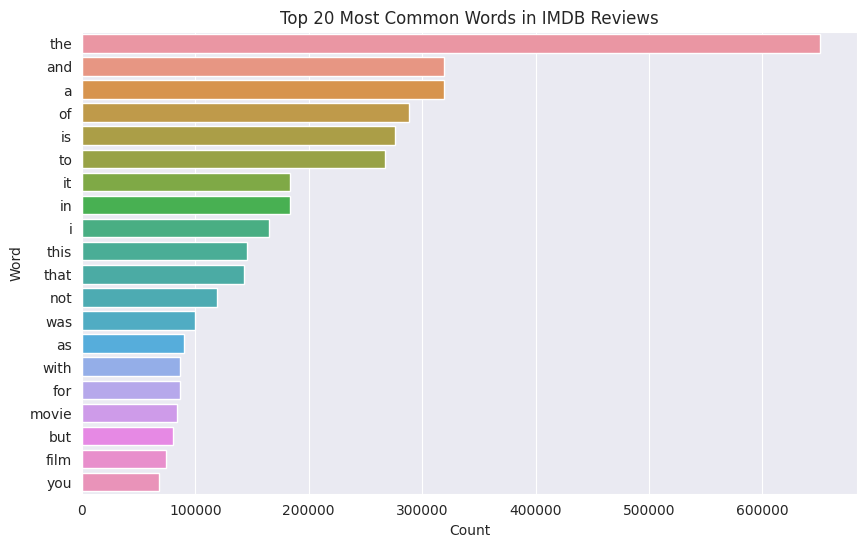

In [120]:
most_common_words = get_most_common_words(df_imdb, 'text', 20)
plot_words_counts(most_common_words, 'Top 20 Most Common Words in IMDB Reviews')

### Häufigkeit von N-grammen

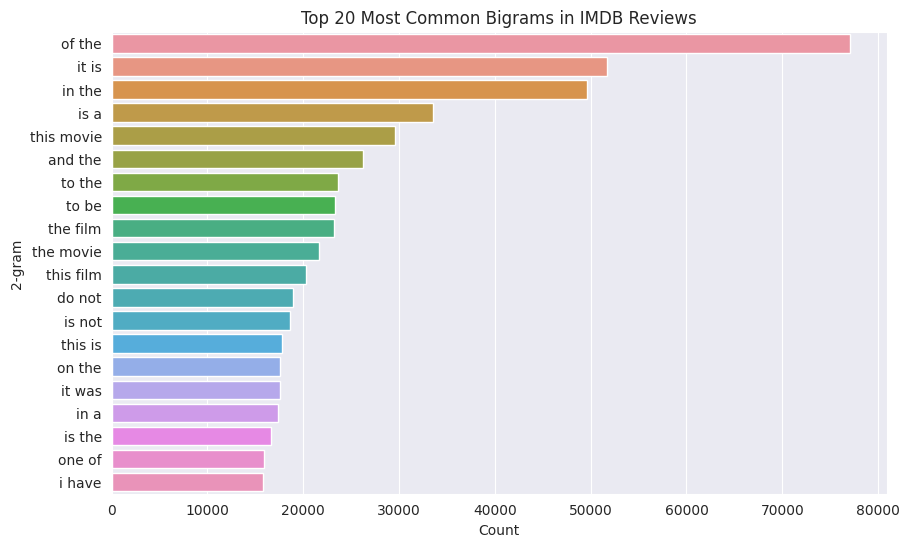

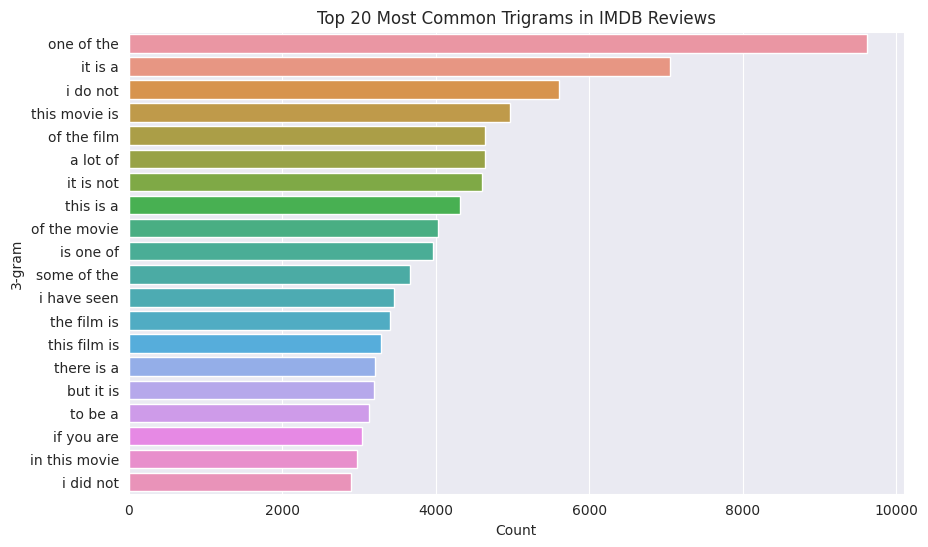

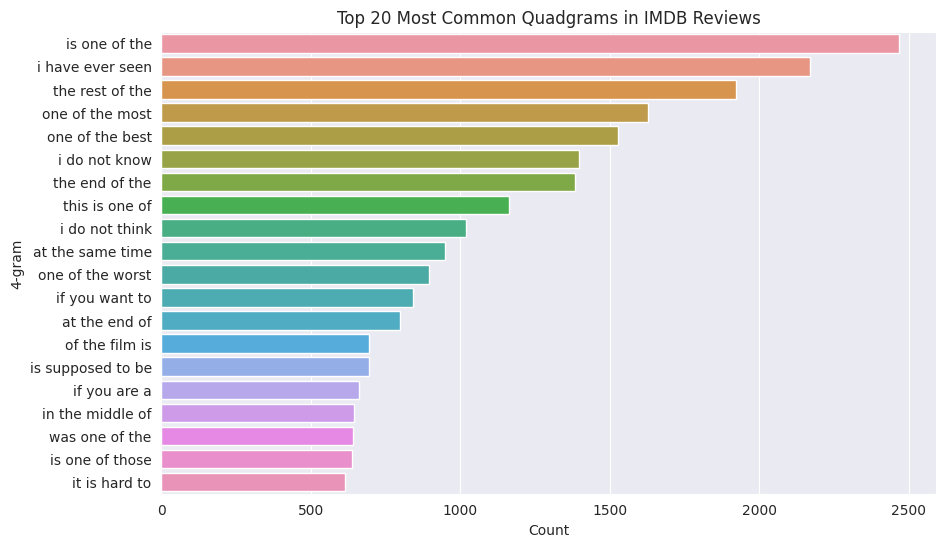

In [121]:
most_common_bigrams = get_most_common_ngrams(df_imdb, 'text', 2, 20)
most_common_trigrams = get_most_common_ngrams(df_imdb, 'text', 3, 20)
most_common_quadgrams = get_most_common_ngrams(df_imdb, 'text', 4, 20)

plot_ngrams_counts(most_common_bigrams, 'Top 20 Most Common Bigrams in IMDB Reviews')
plot_ngrams_counts(most_common_trigrams, 'Top 20 Most Common Trigrams in IMDB Reviews')
plot_ngrams_counts(most_common_quadgrams, 'Top 20 Most Common Quadgrams in IMDB Reviews')

In [122]:
positive_reviews = df_imdb[df_imdb['sentiment'] == 1]
negative_reviews = df_imdb[df_imdb['sentiment'] == 0]

print('Number of Positive Reviews: {}'.format(len(positive_reviews)))
print('Number of Negative Reviews: {}'.format(len(negative_reviews)))

print('Percent of Positive Reviews: {}%'.format(round(len(positive_reviews) / len(df_imdb) * 100, 2)))
print('Percent of Negative Reviews: {}%'.format(round(len(negative_reviews) / len(df_imdb) * 100, 2)))

Number of Positive Reviews: 25000
Number of Negative Reviews: 25000
Percent of Positive Reviews: 50.0%
Percent of Negative Reviews: 50.0%


Der Datensatz ist perfekt ausgewogen mit jeweils 25000 positiven und 25000 negativen Bewertungen, die jeweils 50% des gesamten Datensatzes ausmachen.

**Positive Reviews**

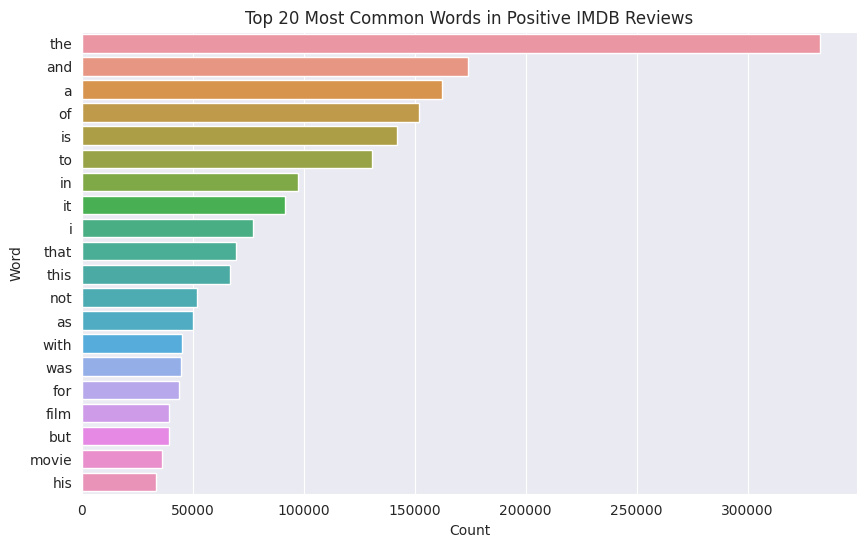

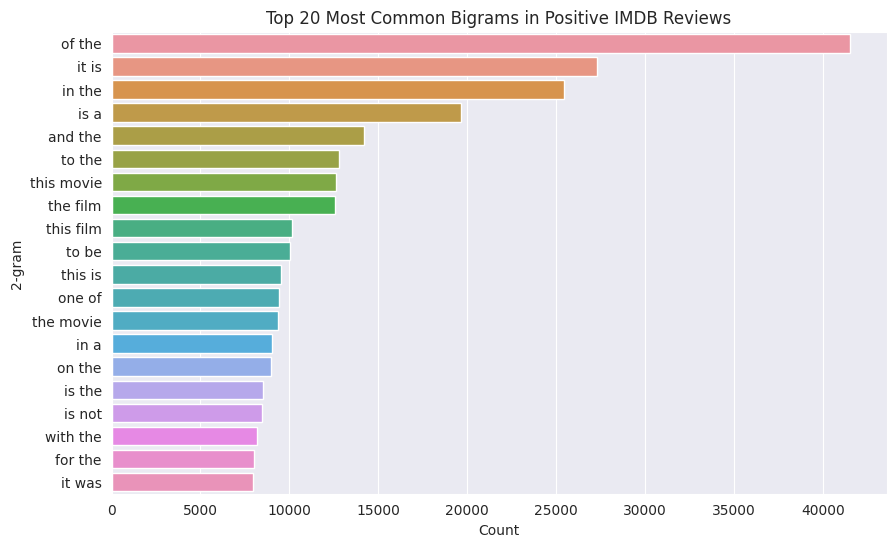

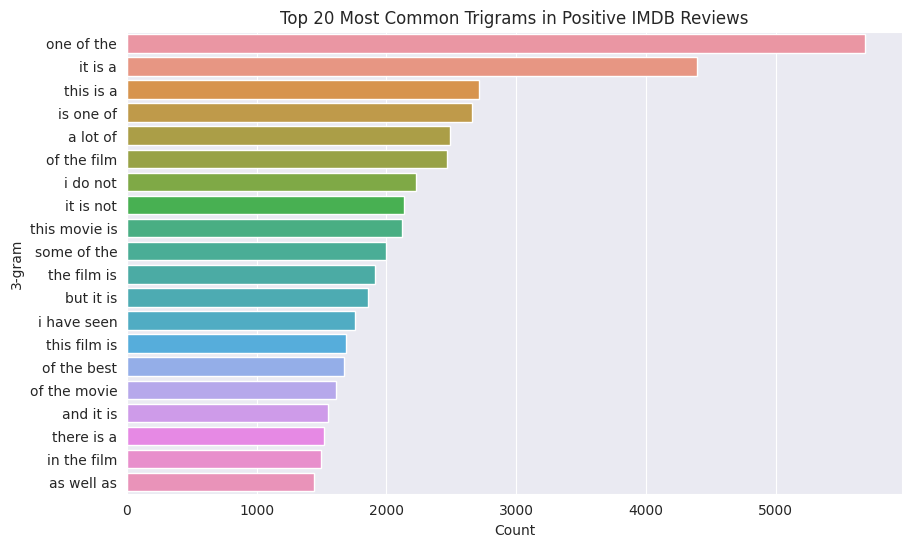

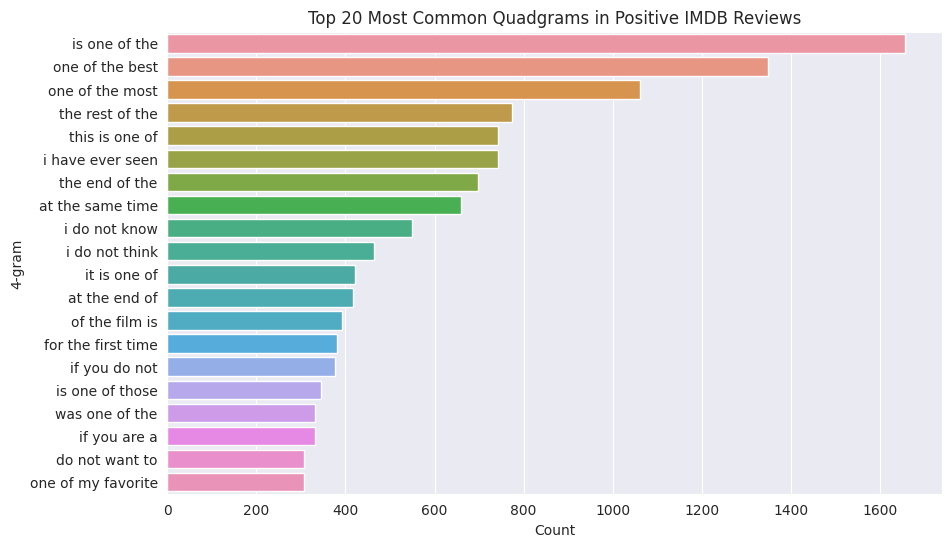

In [123]:
most_common_pos_words = get_most_common_words(positive_reviews, 'text', 20)
most_common_pos_bigrams = get_most_common_ngrams(positive_reviews, 'text', 2, 20)
most_common_pos_trigrams = get_most_common_ngrams(positive_reviews, 'text', 3, 20)
most_common_pos_quadgrams = get_most_common_ngrams(positive_reviews, 'text', 4, 20)

plot_words_counts(most_common_pos_words, 'Top 20 Most Common Words in Positive IMDB Reviews')
plot_ngrams_counts(most_common_pos_bigrams, 'Top 20 Most Common Bigrams in Positive IMDB Reviews')
plot_ngrams_counts(most_common_pos_trigrams, 'Top 20 Most Common Trigrams in Positive IMDB Reviews')
plot_ngrams_counts(most_common_pos_quadgrams, 'Top 20 Most Common Quadgrams in Positive IMDB Reviews')

**Negative Reviews**

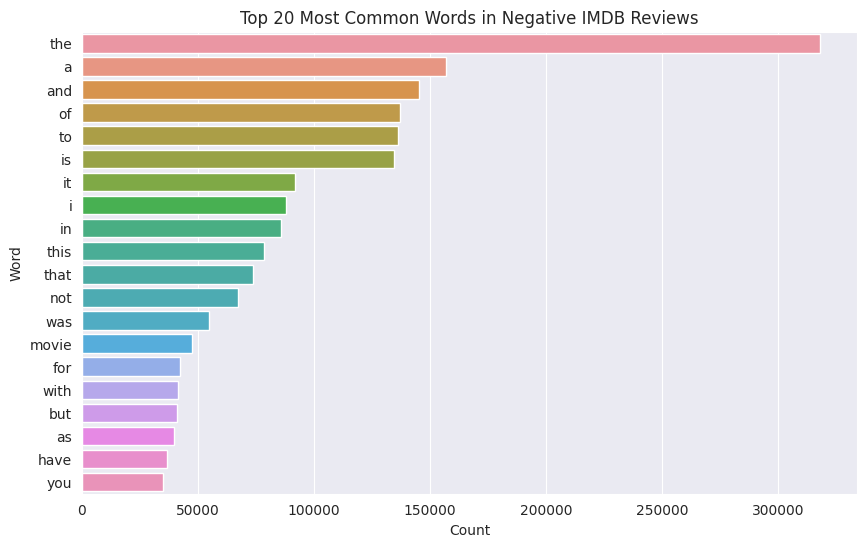

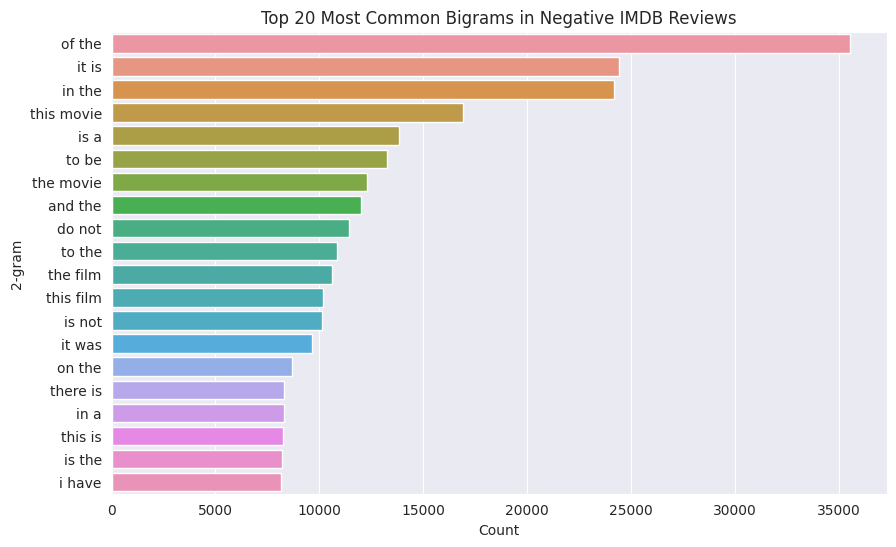

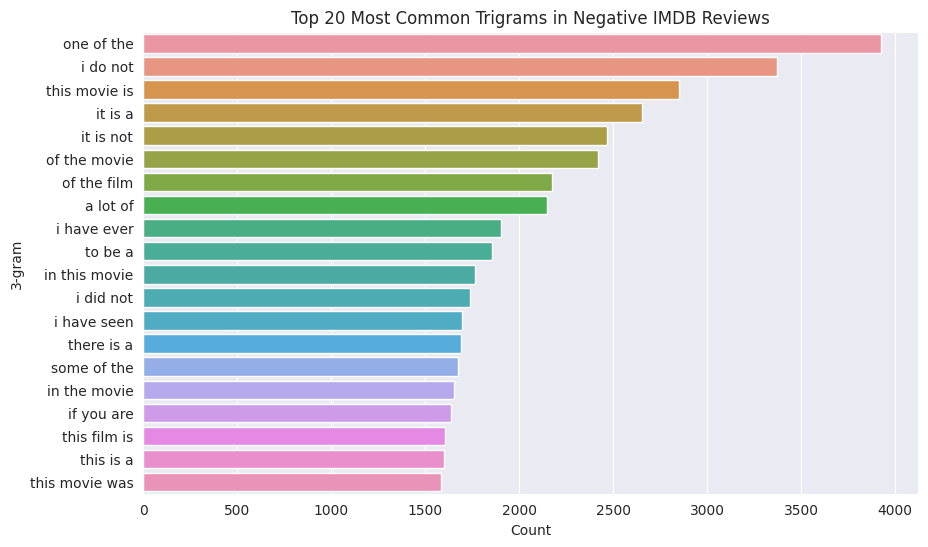

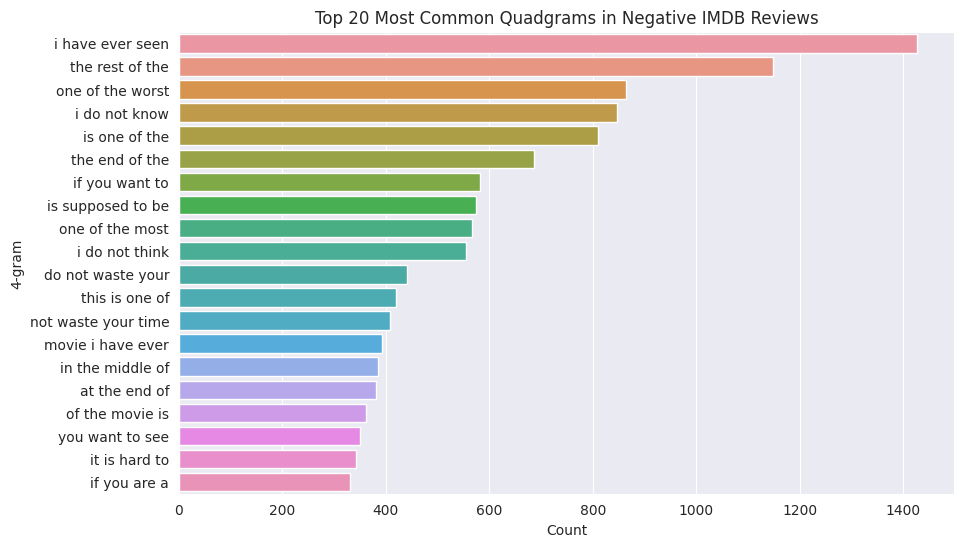

In [124]:
most_common_neg_words = get_most_common_words(negative_reviews, 'text', 20)
most_common_neg_bigrams = get_most_common_ngrams(negative_reviews, 'text', 2, 20)
most_common_neg_trigrams = get_most_common_ngrams(negative_reviews, 'text', 3, 20)
most_common_neg_quadgrams = get_most_common_ngrams(negative_reviews, 'text', 4, 20)

plot_words_counts(most_common_neg_words, 'Top 20 Most Common Words in Negative IMDB Reviews')
plot_ngrams_counts(most_common_neg_bigrams, 'Top 20 Most Common Bigrams in Negative IMDB Reviews')  
plot_ngrams_counts(most_common_neg_trigrams, 'Top 20 Most Common Trigrams in Negative IMDB Reviews')
plot_ngrams_counts(most_common_neg_quadgrams, 'Top 20 Most Common Quadgrams in Negative IMDB Reviews')